# 1. Import Libraries #

In [13]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

# 2. Load Data #

In [2]:
# Read data
file_path = 'data/flights_data.xlsx'
flights_df = pd.read_excel(file_path)

# Display dataset
flights_df.head()

,date,num_flights,roll_average
0,2022-01-01,2501,3133
1,2022-01-02,3685,3211
2,2022-01-03,3745,3236
3,2022-01-04,3313,3247
4,2022-01-05,3166,3239


# 3. Exploratory Data Analysis #

In [3]:
# Number of rows and columns
print("Number of rows: ", flights_df.shape[0])
print("Number of columns: ", flights_df.shape[1])

Number of rows:  1101
Number of columns:  3


In [4]:
# Column data types
flights_df.dtypes

date            datetime64[ns]
num_flights              int64
roll_average             int64
dtype: object

In [5]:
# Drop column roll_average
cleaned_df = flights_df.drop('roll_average', axis=1)
cleaned_df.head()

,date,num_flights
0,2022-01-01,2501
1,2022-01-02,3685
2,2022-01-03,3745
3,2022-01-04,3313
4,2022-01-05,3166


In [6]:
# Check for missing values
print("Number of missing values for each column: ")
cleaned_df.isnull().sum()

Number of missing values for each column: 


date           0
num_flights    0
dtype: int64

In [7]:
# Check for duplicate rows
print("Number of duplicate rows: ")
cleaned_df.duplicated().sum()

Number of duplicate rows: 


0

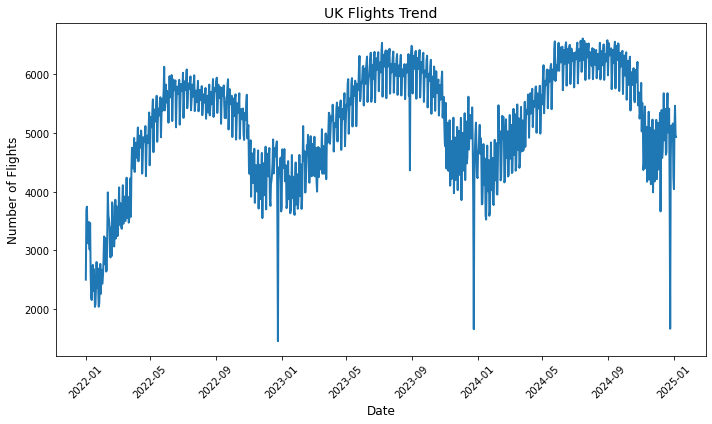

In [ ]:
# Plot a daily trend chart of number of flights
plt.figure(figsize=(10, 6))
plt.plot(cleaned_df.date, cleaned_df.num_flights, linewidth=2)

# Adding labels and title
plt.title('UK Flights Trend', fontsize=14)  # Dark blue title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)

# Formatting the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

# 4. Split the Data #

In [9]:
# Define the split date
split_date = pd.to_datetime('2024-12-01')

# Split the data into training and testing sets
train_data_prophet = cleaned_df[cleaned_df["date"] < split_date]
test_data_prophet = cleaned_df[cleaned_df["date"] >= split_date]

In [10]:
test_data_prophet.head()

,date,num_flights
1065,2024-12-01,4972
1066,2024-12-02,5176
1067,2024-12-03,4378
1068,2024-12-04,4474
1069,2024-12-05,4853


# 5. Model Training #

In [28]:
# Prepare data for Prophet (Prophet expects the dataframe to have columns: 'ds' for datetime and 'y' for values)
train_data_prophet.rename(columns={'date': 'ds', 'num_flights': 'y'}, inplace=True)
test_data_prophet.rename(columns={'date': 'ds', 'num_flights': 'y'}, inplace=True)

# Train Prophet model
prophet_model = Prophet(holidays=make_holidays_df(year_list=[2022, 2023, 2024, 2025], country='UK'), yearly_seasonality=20)
prophet_model.fit(train_data_prophet)

C:\Users\Praveen Satya\AppData\Local\Temp\ipykernel_11156\3389683592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_prophet.rename(columns={'date': 'ds', 'num_flights': 'y'}, inplace=True)
C:\Users\Praveen Satya\AppData\Local\Temp\ipykernel_11156\3389683592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_prophet.rename(columns={'date': 'ds', 'num_flights': 'y'}, inplace=True)
06:44:38 - cmdstanpy - INFO - Chain [1] start processing
06:44:39 - cmdstanpy - INFO - Chain [1] done processing


## 6. Forecasting ##

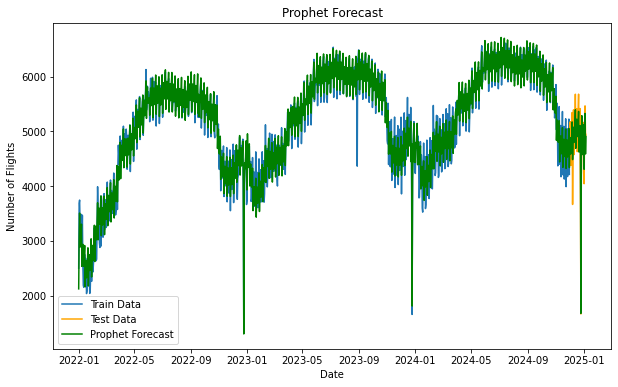

In [78]:
# Make predictions
future = prophet_model.make_future_dataframe(periods=len(test_data_prophet))
forecast_prophet = prophet_model.predict(future)

# Plot Prophet Forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data_prophet['ds'], train_data_prophet['y'], label='Train Data')
plt.plot(test_data_prophet['ds'], test_data_prophet['y'], label='Test Data', color='orange')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(facecolor='#FFFFFF')

In [30]:
# Merge actual and predicted values on the 'ds' column
results = test_data_prophet.merge(forecast_prophet[['ds', 'yhat']], on='ds')

# Extract actual and predicted values
y_true = results['y']  # Actual values
y_pred = results['yhat']  # Predicted values

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 235.34
Mean Squared Error (MSE): 91213.75
Root Mean Squared Error (RMSE): 302.02
Mean Absolute Percentage Error (MAPE): 5.08%


## 7. Anomaly Detection ##

In [45]:
# Create dataframe to save anomalies
anomaly_df = pd.DataFrame(columns=['date','actual','predicted','anomaly_flag'])
anomaly_df['date'] = test_data_prophet['ds']
anomaly_df['actual'] = test_data_prophet['y']
anomaly_df['predicted'] = forecast_prophet['yhat']

# Calculate the residuals (the difference between actual and predicted values)
anomaly_df['residual'] = anomaly_df['actual'] - anomaly_df['predicted']

# Calculate the standard deviation of residuals
std_residual = np.std(anomaly_df['residual'])

# Define the threshold for anomaly detection (2.5 standard deviations)
threshold = 1.5 * std_residual

# Calculate the upper and lower thresholds
anomaly_df['upper_threshold'] = anomaly_df['predicted'] + threshold
anomaly_df['lower_threshold'] = anomaly_df['predicted'] - threshold

# Flag anomalies where the actual value is outside the upper and lower thresholds
anomaly_df['anomaly_flag'] = np.where((anomaly_df['actual'] > anomaly_df['upper_threshold']) | (anomaly_df['actual'] < anomaly_df['lower_threshold']), 1, 0)

# View the anomalies
anomaly_df[anomaly_df['anomaly_flag'] == 1]

,date,actual,predicted,anomaly_flag,residual,upper_threshold,lower_threshold
1071,2024-12-07,3665,4484.398676,1,-819.398676,4937.370711,4031.426641
1088,2024-12-24,3928,4779.942047,1,-851.942047,5232.914082,4326.970012
1095,2024-12-31,4248,4821.045150,1,-573.045150,5274.017185,4368.073116


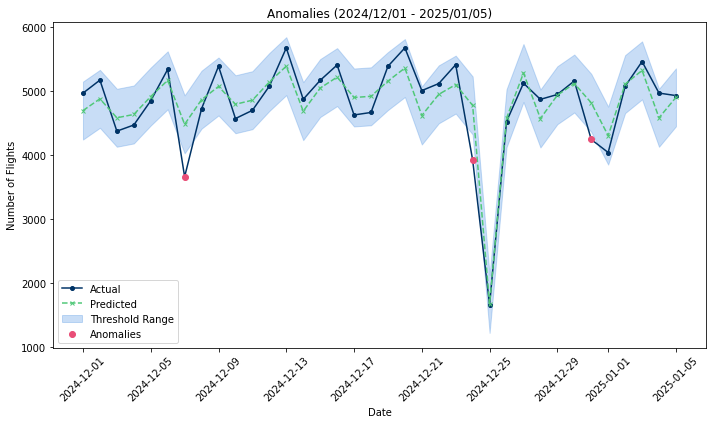

In [68]:
# Plotting the actual values, predicted values, upper and lower thresholds, and anomalies
plt.figure(figsize=(10, 6))

# Plot actual and predicted values
plt.plot(anomaly_df['date'], anomaly_df['actual'], label='Actual', color='#003366', linestyle='-', marker='o', markersize=4)
plt.plot(anomaly_df['date'], anomaly_df['predicted'], label='Predicted', color='#50C878', linestyle='--', marker='x', markersize=4)

# Color the area between upper and lower thresholds
plt.fill_between(anomaly_df['date'], anomaly_df['upper_threshold'], anomaly_df['lower_threshold'], color='#4A90E2', alpha=0.3, label='Threshold Range')

# Highlight anomalies
anomalies = anomaly_df[anomaly_df['anomaly_flag'] == 1]
plt.scatter(anomalies['date'], anomalies['actual'], color='#E94E77', label='Anomalies', zorder=5)

# Labeling and title
plt.title('Anomalies (2024/12/01 - 2025/01/05)')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(loc='lower left', facecolor='#FFFFFF')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set background
plt.gcf().patch.set_facecolor('#FFFFFF')
plt.gca().set_facecolor('#FFFFFF')

# Show the plot
plt.tight_layout()
plt.show()
